In [12]:

suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(gridExtra, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(ggplot2, quietly = TRUE, warn.conflicts = FALSE))


set.seed(27182)


### In this module you will learn how to:

1. Split our data into train-test-validation samples
2. Implement and use cross-validation
2. Use cross-validation to select the of terms to include in a polynomial regression


Instead of using real data we are going to generate our own. Why might we want to do this? We want to see if cross-validation works. If we use real data we don't know what the true model looks like. If we create the model ourselves we can determine if the process actually works!

### Generating Data
Lets generate data from a fourth order polynomial: $y=\beta_0+\beta_1x+\beta_2x^2+\beta_3x^3+\beta_4x^4+\varepsilon$

The following code snippet shows how we can do this.


In [2]:

N = 1500                                       
# Sample size
beta_true = matrix(c(.2,-.01,.3,-.005))            
# coefficient vector
x0 = array(1,c(N,1))                          
#intercept is separate 
x1 = c(runif(N,-2,2))                         
# generate N uniform rvs between -2,2
x2 = x1^2                                    
# squared    
x3 = x1^3                                    
# cubed     
x4 = x1^4                                    
# 4th power 
X = cbind(x1,x2,x3,x4)                       
# X is the concatenation of 4 column vectors     
y = x0+X%*%beta_true + c(rnorm(N)*1.5)           
# y is generated from a 4th order polynomial with N(0,2.25) errors   
Xvar = data.frame(cbind(y,x1))               
# creates a data frame from the "observed" covariates y and x 
colnames(Xvar) = c('y', 'X')                   
# label the columns of the dataframe     


### Visualization 

In practice we don't know the order of the polynomial. We only observe observations from $y$ and $x$. A great way to begin our examination of the truth would be to visualize the relationship through a scatter plot!



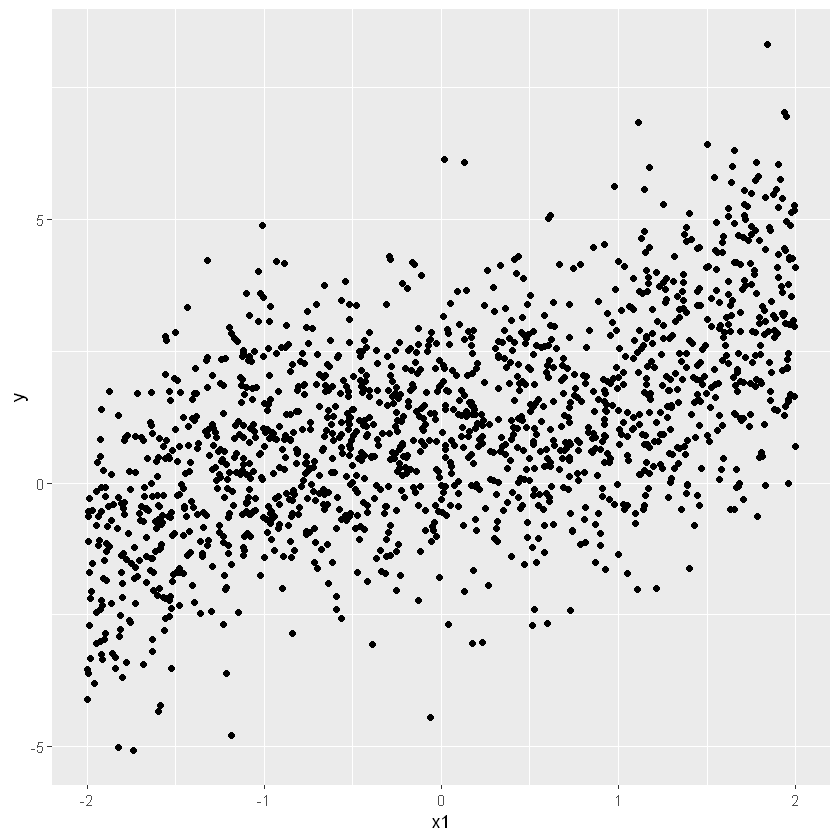

In [3]:
qplot(x1,y)                         
# ggplot looks nicer than built in plotting in R (qplot stands for quick plot)


### What do we see?

The scatter plot suggests the relationship is nonlinear, but we need still don't know how many terms to include in a polynomial regression.

### Sample Splitting

Remember that when we are using data-driven techniques our first step will be to split our sample into a validation set and our training/test set. 

1. Training set: subset of the data used to develop models (learn)
2. Test set: subset of the data used to further fine-tune model parameters (learn better)
3. Validation set: subset of the data used to approximate out of sample fit (ensure you learned the right thing)


##### Note: If your data has particular structure (panel, clustering, etc) you want to be careful about how you split/shuffle the data. In this case we know the structure and it will be ok to just slice off a random subsample.


The following snippet is an example of a function. We will use a few of these throughout the course just to get an idea for what they look like. In this function we specify the data and how much of that data needs to be set asside for validation, the default is $10\%$.


In [4]:
#Splitting the data

data_split = function(data,split=.1){

    N = dim(data)[1]                         
    random = sample(1:N,N,replace=F)          
    # Randomly choose the index for the splits
    
    data = data[random,]                      
    # Shuffle the data
    
    test = data[1:round(N*split),]           
    train = data[(round(N*split)+1):N,]
    # Split the data into train/test
    
    return(list(train,test))
}


tmp = data_split(Xvar) 
train_test = tmp[[1]]
validation = tmp[[2]]


### Number of terms?


Before we can begin to utilize cross-validaiton we need to choose $P$, the number of models we are considering. The larger $P$ is, the longer our computation will take. However, we want to make sure the true $P$ is among the choices. This choice is going to be somewhat arbitrary, but higher order polynomial terms tend to have very small coefficients so we should be able to get away with something around $P=8$. 

### Number of folds?

Remember we also have to choose the number of folds $k$. In general we want to choose $k$ small enough that the correlation between samples doesn't get too large, but $k$ large enough that we split enough times. The standard choices are also a bit arbitrary but perform well in practice $k=5$ or $k=10$.

### How do we evaluate the model?

The goal is to minimize the out-of-sample mean squared error (MSE). Recall that cross-vadliation allows us to evaluate the model on the fold that is left out at each iteration! This procedure allows us to  ”simulate” a new sample.


### Cross-Validation

Let's go ahead and look at $p={1,2,\dots,8}$ and $k=5$. The first model will be the simple linear case: $y=\beta_0+\beta_1 x+\varepsilon$.

There are many packages that implement cross-validation in R. We will use a few of these in later modules, but just so you can see what is happening under the hood this is a direct implementation.



In [5]:


num_folds = 5                                          
# Number of folds
N = dim(train_test)[1]                                 
# Number of observations
p = dim(train_test)[2]                                 
# Number of covariates
sel = diag(num_folds)                                  
# One way of selecting train/test splits is through basis vectors
size = round(dim(train_test)[1]/num_folds)             
# The size of each 
train = array(,dim=c(size*(num_folds-1),p,num_folds))  
# 3d matrix to store training data for each iteration
test = array(,dim=c(size,p,num_folds))                 
# 3d matrix to store test data for each iteration
MSE = array(,c(num_folds))                             
# 2d matrix to store MSE evaluated on the test data   
yhat = array(,c(N,num_folds))

for (i in 1:num_folds){ 
    
    # This block just assigns train/test to 
    # each fold there are many ways to accomplish this

    test[,,i] = as.matrix(train_test)[
        as.logical(kronecker(array(1,c(size,1)),sel[i,])),]
    train[,,i] = as.matrix(train_test)[
        as.logical(kronecker(array(1,c(size,1)),(1-sel[i,]))),]
    train_tmp = data.frame(train[,,i])
    test_tmp = data.frame(test[,,i])
    X_train = as.data.frame(train_tmp[,2:p])
    X_test = as.data.frame(test_tmp[,2:p])
    colnames(X_test) = colnames(X_train)

    # Once we have our train/test folds we want to estimate the
    # model on the training set and predict on the test
    
    yhat[,i] = predict(lm(train_tmp[,1]~.,data = X_train),newdata=X_test)                                   

    MSE[i] = mean((test_tmp[,1]-yhat[,i])^2)          
    # output the MSE evaluated on the test data
                          
}

cat('MSE evaluated on each test fold:', MSE)

MSE evaluated on each test fold: 2.479901 2.644414 2.340579 2.467246 2.585332

### Cross-Validation Results

For each fold we have a value of the "out-of-sample" MSE. We typically want a single number to evaluate the overall performance of the model. We can get a general idea of the out-of-sample performance of our model by taking the mean or median of these values.


In [6]:
cat('Mean: ',mean(MSE),'\n')

cat('Median: ',median(MSE))

Mean:  2.503494 
Median:  2.479901

### Visualizing the Splits

We can visualize what we've done by looking at a colored scatter plot. Remember, for each fold we are fitting the model on a subsample of the data and evaluating it on the rest! The blue dots are the observations we used as training data in that particular iteration, the red dots refer to the test observations. The black line is the fitted line based on the test data.
##### Note: The line is straight as we are fitting the simple linear model

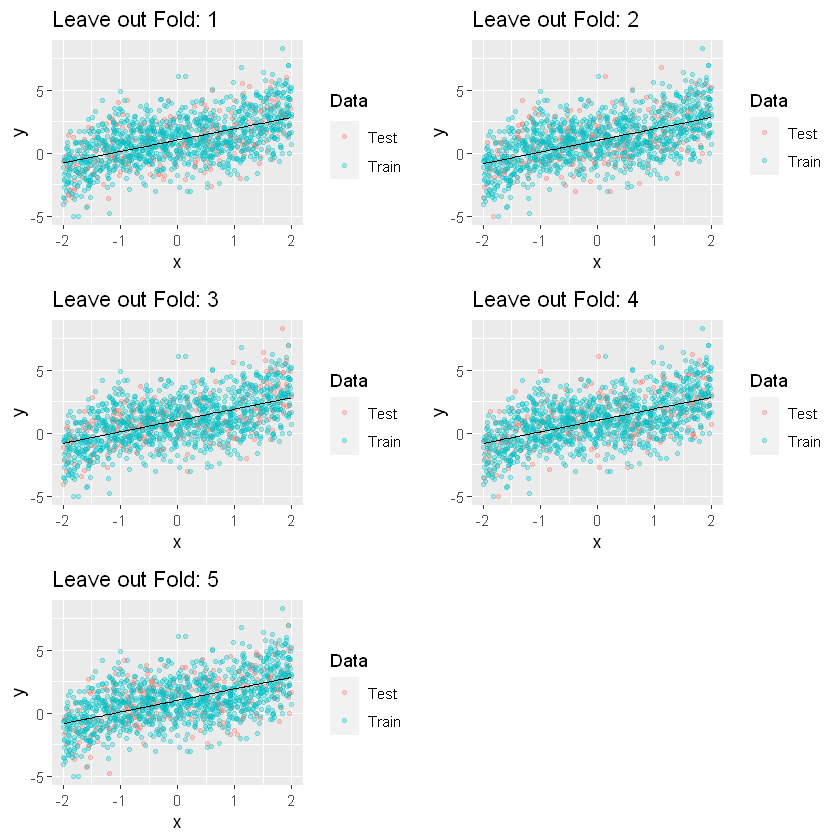

In [7]:
for (i in 1:5){
    visual = data.frame(cbind(rbind(test[,,i],train[,,i]),
                              as.logical(rbind(array(0,c(size,1)),
                               array(1,c((num_folds-1)*size,1))))))
    
    colnames(visual) = c('y','x','train')
    pred = data.frame(cbind(yhat[,i],test[,2,i]))
    colnames(pred) = c('ytest','xtest')

    assign(paste('p',i,sep=''), ggplot(visual , aes(x = x, y = y)) +
           geom_point(aes(color = factor(train,labels=c("Test","Train"))),alpha=.3,size=1) +
           geom_line(data=pred, aes(x=xtest,y=ytest)) + 
           ggtitle(paste('Leave out Fold: ',i,sep=''))+
           labs(color="Data"))
}

grid.arrange(p1,p2,p3,p4,p5,ncol=2)

### Fitting all 8 Models

Now that we've seen how this works for one model choice, let's go ahead and estimate the remaining models. Again for illustration we wrote out a function that will do cross-validation in the linear model.


In [8]:
# Wrapping our previous code into a function

CV_linear = function(train_test,num_folds){
    N = dim(train_test)[1]                                 
    # Number of observations
    
    p = dim(train_test)[2]                                 
    # Number of covariates
    
    sel = diag(num_folds)                                  
    # One way of selecting train/test splits is through basis vectors
    
    size = round(dim(train_test)[1]/num_folds)             
    # The size of each 
    
    train = array(,dim=c(size*(num_folds-1),p,num_folds))  
    # 3d matrix to store training data for each iteration
    
    test = array(,dim=c(size,p,num_folds))                 
    # 3d matrix to store test data for each iteration
    
    MSE = array(,c(num_folds))                             
    # 2d matrix to store MSE evaluated on the test data
    
    yhat = array(,c(N,num_folds))

    for (i in 1:num_folds){                                  
        # This block just assigns train/test to each fold

        test[,,i] = as.matrix(train_test)[
            as.logical(kronecker(array(1,c(size,1)),sel[i,])),]
        train[,,i] = as.matrix(train_test)[
            as.logical(kronecker(array(1,c(size,1)),(1-sel[i,]))),]
        train_tmp = data.frame(train[,,i])
        test_tmp = data.frame(test[,,i])
        X_train = as.data.frame(train_tmp[,2:p])
        X_test = as.data.frame(test_tmp[,2:p])
        colnames(X_test) = colnames(X_train)
        
        # Once we have our train/test folds we want to estimate 
        # the model on the training set and predict on the test

        yhat[,i] = predict(lm(train_tmp[,1]~.,data = X_train),newdata=X_test) 
                                                                             
        MSE[i] = mean((test_tmp[,1]-yhat[,i])^2)            
        # output the MSE evaluated on the test data
                 
        }
      return(MSE)
}


models = function(train_test,num_folds){
    mse = array(,c(8,num_folds))
    for (i in seq(1,8,1)){                                                     
        # Iterate through the models and get CV estimates
        
        if (i>1){
          train_test[paste('X',i,sep="")] = train_test[,1]^i
          mse[i,] = CV_linear(train_test,num_folds)
          } else{
          mse[i,] = CV_linear(train_test,num_folds)
          }

        }
    return(mse)
}

mse = models(train_test,5)

### Cross-Validation Results -- All 8 Models

Now that we have performed 5-fold cross validation on all $8$ of our models! Let's see which one performed best (in terms of average "out-of-sample" MSE)

In [9]:
model.names = NULL
for (i in 1:8){
    model.names[i] = paste('model',i,sep='')
    }
CV_mse = data.frame(mse,row.names=model.names)
colnames(CV_mse) = seq(1,5,1)

In [10]:
CV_mse

cat('5-fold CV picks: Model', which.min(rowMeans(CV_mse))[1])

## Display a table for MSE and print the minimum

,1,2,3,4,5
model1,2.4799013,2.6444139,2.340579,2.4672455,2.5853321
model2,1.8176123,1.7026965,1.460791,1.7009678,1.9134005
model3,1.2743410,1.2915052,1.966354,1.1822887,1.3996514
model4,0.7710116,0.8442342,1.023111,0.7910482,0.8094308
model5,0.7674733,0.8405352,2.858941,0.7927283,0.8057537
model6,0.4640511,0.4407953,3.591542,0.4074398,0.4532309
model7,0.4752736,0.3973252,4.015236,0.4089919,0.4004693
model8,0.2943553,0.2825031,29.520720,0.2509071,0.2987708


5-fold CV picks: Model 4

### Does Cross-Validation Work?

Well that's pretty cool. Cross validation picked the right model! Although we knew what the correct model was, we didn't use that information anywhere in the estimation. The key thing was ensuring that the correct model was available for cross-validation to select. 

Will this always happen? Unfortunately, cross-validation isn't perfect, but as long as the procedure is done properly, we will choose the right model most of the time!

### Validation Performance

Now that we've chosen the model we can go ahead and estimate our model with the validation data and see how we do.

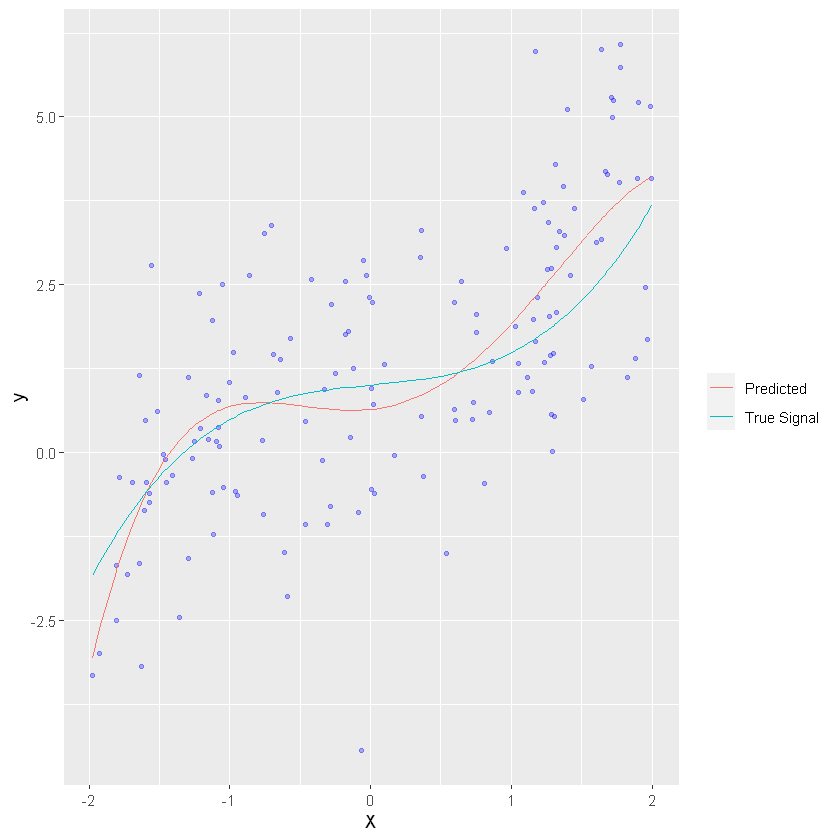

In [11]:


validation['X2'] = (validation$X)^2
validation['X3'] = (validation$X)^3
validation['X4'] = (validation$X)^4
# Create polynomial terms

X = validation[,2:5]
y = validation[,1]
y_true = rep(1,dim(validation)[1]) + as.matrix(X)%*%beta_true

# slice off validation data and generate noise free truth

OLS = lm(y~.,data = X)

pred = predict(OLS)
pred = cbind(X,pred)
true = cbind(X,y_true)

ggplot(validation , aes(x = X, y = y)) +
           geom_point(color = 'blue',alpha=.3,size=1) +
           geom_line(data=pred, aes(x=X,y=pred,color="Predicted")) +
           geom_line(data=true, aes(x=X,y=y_true,color='True Signal')) +
           theme(legend.title=element_blank())

# Plot the validation data with the prediction and the truth together

### Exercise: Module 1

We have learned how to partition the data using our own functions in R. Additionally, we have seen how to utilize this idea in performing cross-vadliation. We have expanded our code for partitioning data into a function that will perform this cross-validation for us. Now that we have all of these functions at our disposal it is very easy for us to change the number of folds in the cross-validation procedure.

1. Redo the analysis using 10-fold CV.

2. Does the procedure still pick the right model?



We found that the 5 and 10 fold cross-validation procedures both gave us the same model! It appears that at least in this case our results are robust to the number of folds we pick, so long as that number is reasonable. In practice we may want to try a few different values for $k$.